# Tidal Heating and Torque versus Semi-major Axis
An example of using TidalPy functions


In [1]:
# Setup Jupyter environment and load in useful packages 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import G

In [2]:
# Delete me!
try:
    import TidalPy
except ModuleNotFoundError:
    import sys, os
    cwd = os.getcwd()
    tpy = os.path.join(cwd, os.pardir)
    if tpy not in sys.path:
        sys.path.append(tpy)

In [3]:
# Import TidalPy 
from TidalPy.constants import mass_pluto, radius_pluto
from TidalPy.utilities.conversions import days2rads, m2Au, Au2m, orbital_motion2semi_a, semi_a2orbital_motion
from TidalPy.rheology import effective_rigidity, complex_love, find_complex_compliance, complex_compliances,\
    rheology_styles
from TidalPy.orbit import nsr_modes, spin_sync_modes

In [4]:
# Star and Planet Properties
mass_charon = .124 * mass_pluto
radius_charon = .5093 * radius_pluto
modern_semi_major_axis = 1.9591e7

bulk_density_pluto = mass_pluto / ((4/3) * np.pi * radius_pluto**3)
surface_gravity_pluto = G * mass_pluto / radius_pluto**2
bulk_density_charon = mass_charon / ((4/3) * np.pi * radius_charon**3)
surface_gravity_charon = G * mass_charon / radius_charon**2

# Material Properties
shear = 5.0e10
viscosity = 1.0e20
compliance = shear**-1

# Self-Gravity
eff_rigid_pluto = effective_rigidity(shear, surface_gravity_pluto, radius_pluto, bulk_density_pluto)
eff_rigid_charon = effective_rigidity(shear, surface_gravity_charon, radius_charon, bulk_density_charon)
beta_pluto = radius_pluto * bulk_density_pluto * surface_gravity_pluto
beta_charon = radius_charon * bulk_density_charon * surface_gravity_charon
moi_pluto = (2. / 5.) * mass_pluto * radius_pluto**2
moi_charon = (2. / 5.) * mass_charon * radius_charon**2


In [5]:
# Rheological Constants
zeta = 1.0
alpha = 0.3
fixed_q = 10
fixed_q2 = 1000

# Get Rheological Functions by Searching...
# Tell it the layer type
find_complex_compliance.default_key = 'rock'
maxwell_comp, _, _ = find_complex_compliance('Maxwell')
# or by direct import...
andrade_comp = complex_compliances.andrade
fixed_q_comp = complex_compliances.fixed_q

# Create Helper Functions
maxwell_neg_imk_func = \
    lambda tidal_mode, beta, eff_rigid: \
        -np.imag(complex_love(maxwell_comp(compliance, viscosity, tidal_mode), shear, eff_rigid))
andrade_neg_imk_func = \
    lambda tidal_mode, beta, eff_rigid: \
        -np.imag(complex_love(andrade_comp(compliance, viscosity, tidal_mode, alpha, zeta), shear, eff_rigid))
fixed_q_neg_imk_func = \
    lambda tidal_mode, beta, eff_rigid: \
        -np.imag(complex_love(fixed_q_comp(compliance, viscosity, tidal_mode, fixed_q, beta), shear, eff_rigid))
fixed_q2_neg_imk_func = \
    lambda tidal_mode, beta, eff_rigid: \
        -np.imag(complex_love(fixed_q_comp(compliance, viscosity, tidal_mode, fixed_q2, beta), shear, eff_rigid))

# Comment out (or add in more) lines corresponding to rheologies you don't want to plot
neg_imk_funcs = {
    'Maxwell': (maxwell_neg_imk_func, '-g'),
    'Andrade': (andrade_neg_imk_func, '-b'),
    # f'Fixed-Q, Q={fixed_q}': (fixed_q_neg_imk_func, '-y'),
    # f'Fixed-Q, Q={fixed_q2}': (fixed_q2_neg_imk_func, '-c')
}

In [6]:
# Setup Domain of Study 
spin_frequency = days2rads(6.3872304)
semi_major_axis_scale = np.linspace(.2, 2.5, 1000)

# Make sure that the semi-major axis actually has the resonances
resonances = np.asarray([spin_frequency, 2.*spin_frequency, spin_frequency/2., (2/3)*spin_frequency, (3/2)*spin_frequency])
resonances = orbital_motion2semi_a(resonances, mass_pluto, mass_charon) / modern_semi_major_axis
semi_major_axis_scale = np.concatenate((semi_major_axis_scale, resonances))
semi_major_axis_scale = np.sort(semi_major_axis_scale)

# Conversions
semi_major_axis = semi_major_axis_scale * modern_semi_major_axis
orbital_frequency = semi_a2orbital_motion(semi_major_axis, mass_pluto, mass_charon)

# Spin-rate needs to be the same shape as orbital frequency
spin_frequency = days2rads(2.) * np.ones_like(orbital_frequency)
eccentricity = np.asarray([0.2])
inclination = np.asarray([np.deg2rad(5.)])
loc = np.abs(orbital_frequency - days2rads(2.0)).argmin()

In [7]:
# Find Regular Tidal Modes (only one mode = orbital motion)
tidal_modes, tidal_freqs, heating_coefficients, torque_coefficients = \
    spin_sync_modes(orbital_frequency, eccentricity, inclination)
freq_sync = tidal_freqs[0]
heating_coeff_sync = heating_coefficients[0]
torque_coeff_sync = torque_coefficients[0]

# Find NSR Tidal Modes
# Note: We are assuming here that pluto and charon maintain the same spin-rate relative to each other (but not to the 
#    orbital period).
tidal_modes_NSR, tidal_freqs_NSR, heating_coefficients_NSR, torque_coefficients_NSR = \
    nsr_modes(orbital_frequency, spin_frequency, eccentricity, inclination)

In [8]:
# Calculate Tidal Heating and Torque and Plot
tidal_susceptibility_pluto = (3. / 2.) * G * mass_pluto**2 * radius_pluto**5 / semi_major_axis**6
tidal_susceptibility_charon = (3. / 2.) * G * mass_charon**2 * radius_charon**5 / semi_major_axis**6
tidal_heating_pluto_byrheo = dict()
tidal_torque_real_pluto_byrheo = dict()
tidal_torque_pluto_byrheo = dict()
tidal_torque_neg_pluto_byrheo = dict()
tidal_heating_charon_byrheo = dict()
tidal_torque_real_charon_byrheo = dict()
tidal_torque_charon_byrheo = dict()
tidal_torque_neg_charon_byrheo = dict()

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    
    # Pluto First
    heating_scaled_imk = \
        sum([imk_func(freq, beta_pluto, eff_rigid_pluto) * heat_coeff for freq, heat_coeff in
             zip(tidal_freqs_NSR, heating_coefficients_NSR)])
    tidal_heating = tidal_susceptibility_pluto * heating_scaled_imk
    torque_scaled_imk = \
        sum([imk_func(freq, beta_pluto, eff_rigid_pluto) * torque_coeff for freq, torque_coeff in
             zip(tidal_freqs_NSR, torque_coefficients_NSR)])
    tidal_torque = tidal_susceptibility_pluto * torque_scaled_imk
    tidal_torque_real_pluto_byrheo[rheo_name] = np.copy(tidal_torque)
    
    # Make a negative torque that we will plot in a different color (due to log scaling)
    tidal_torque_neg = np.zeros_like(tidal_torque)
    tidal_torque_neg[tidal_torque < 0.] = -tidal_torque[tidal_torque < 0.]
    tidal_torque[tidal_torque <= 0.] = np.nan
    tidal_torque_neg[tidal_torque_neg <= 0.] = np.nan
    
    # Store Values
    tidal_heating_pluto_byrheo[rheo_name] = tidal_heating
    tidal_torque_pluto_byrheo[rheo_name] = tidal_torque
    tidal_torque_neg_pluto_byrheo[rheo_name] = tidal_torque_neg
    
    # Now charon
    heating_scaled_imk = \
        sum([imk_func(freq, beta_charon, eff_rigid_charon) * heat_coeff for freq, heat_coeff in
             zip(tidal_freqs_NSR, heating_coefficients_NSR)])
    tidal_heating = tidal_susceptibility_charon * heating_scaled_imk
    torque_scaled_imk = \
        sum([imk_func(freq, beta_charon, eff_rigid_charon) * torque_coeff for freq, torque_coeff in
             zip(tidal_freqs_NSR, torque_coefficients_NSR)])
    tidal_torque = tidal_susceptibility_charon * torque_scaled_imk
    tidal_torque_real_charon_byrheo[rheo_name] = np.copy(tidal_torque)
    
    # Make a negative torque that we will plot in a different color (due to log scaling)
    tidal_torque_neg = np.zeros_like(tidal_torque)
    tidal_torque_neg[tidal_torque < 0.] = -tidal_torque[tidal_torque < 0.]
    tidal_torque[tidal_torque <= 0.] = np.nan
    tidal_torque_neg[tidal_torque_neg <= 0.] = np.nan
    
    # Store Values
    tidal_heating_charon_byrheo[rheo_name] = tidal_heating
    tidal_torque_charon_byrheo[rheo_name] = tidal_torque
    tidal_torque_neg_charon_byrheo[rheo_name] = tidal_torque_neg
    

### Plot Set 1a - Pluto

Lighter colors on the tidal torque plot indicate a negative torque.


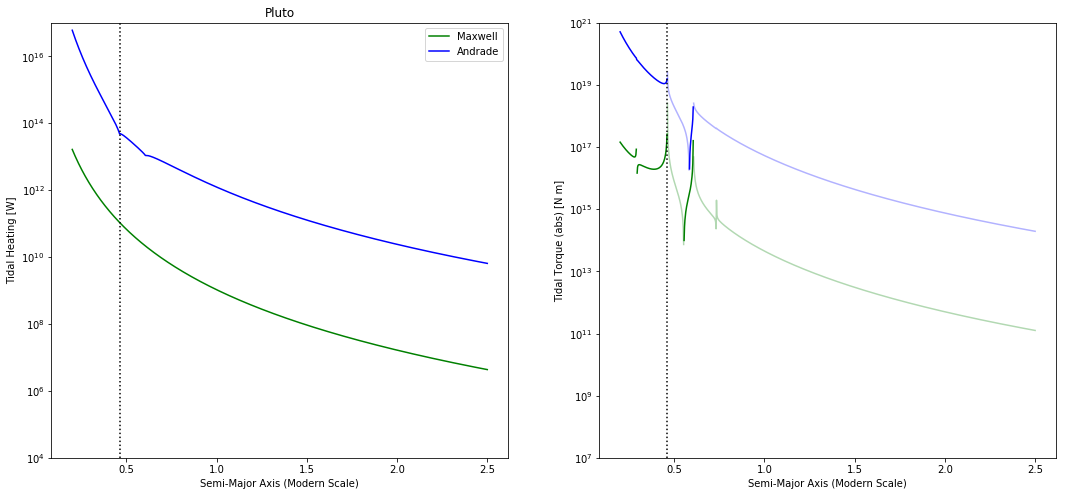

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    
    # Get Data
    tidal_heating = tidal_heating_pluto_byrheo[rheo_name]
    tidal_torque = tidal_torque_pluto_byrheo[rheo_name]
    tidal_torque_neg = tidal_torque_neg_pluto_byrheo[rheo_name]
    
    # Heating Plot
    axes[0].plot(semi_major_axis_scale, tidal_heating, style, label=rheo_name)
    
    # Torque Plot
    axes[1].plot(semi_major_axis_scale, tidal_torque, style, label=rheo_name)
    axes[1].plot(semi_major_axis_scale, tidal_torque_neg, style, label=rheo_name, alpha=0.3)
    
# Add spin-sync location
spin_sync_semi_a_au = orbital_motion2semi_a(spin_frequency[0], mass_pluto, mass_charon) / modern_semi_major_axis
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_title('Pluto')
axes[0].set_xlabel('Semi-Major Axis (Modern Scale)')
axes[0].set_ylabel('Tidal Heating [W]')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis (Modern Scale)')
axes[1].set_ylabel('Tidal Torque (abs) [N m]')
axes[1].set_yscale('log')
axes[0].set_ylim((1e4, 1e17))
axes[1].set_ylim((1e7, 1e21))
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()

### Plot Set 1b - charon

Lighter colors on the tidal torque plot indicate a negative torque.


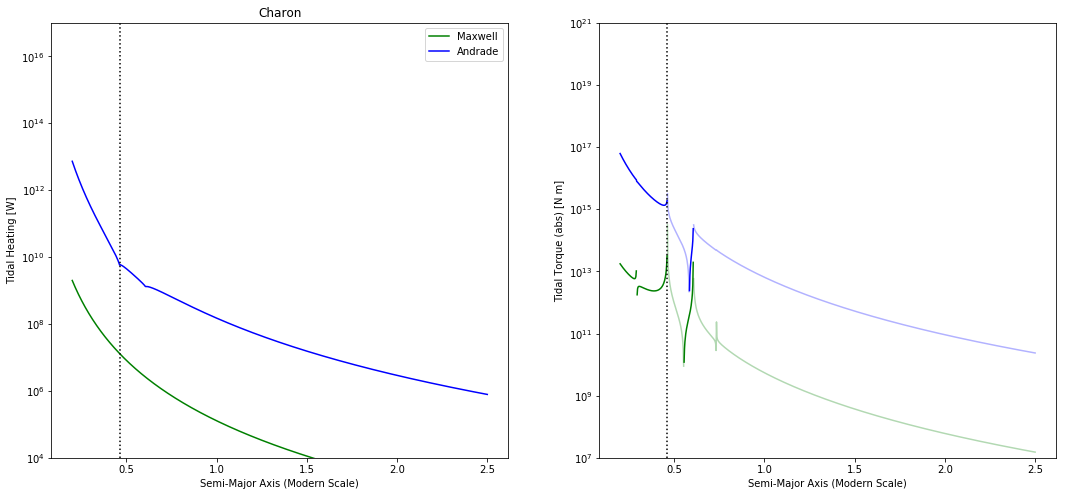

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    
    # Get Data
    tidal_heating = tidal_heating_charon_byrheo[rheo_name]
    tidal_torque = tidal_torque_charon_byrheo[rheo_name]
    tidal_torque_neg = tidal_torque_neg_charon_byrheo[rheo_name]
    
    # Heating Plot
    axes[0].plot(semi_major_axis_scale, tidal_heating, style, label=rheo_name)
    
    # Torque Plot
    axes[1].plot(semi_major_axis_scale, tidal_torque, style, label=rheo_name)
    axes[1].plot(semi_major_axis_scale, tidal_torque_neg, style, label=rheo_name, alpha=0.3)
    
# Add spin-sync location
spin_sync_semi_a_au = orbital_motion2semi_a(spin_frequency[0], mass_pluto, mass_charon) / modern_semi_major_axis
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_title('Charon')
axes[0].set_xlabel('Semi-Major Axis (Modern Scale)')
axes[0].set_ylabel('Tidal Heating [W]')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis (Modern Scale)')
axes[1].set_ylabel('Tidal Torque (abs) [N m]')
axes[1].set_yscale('log')
axes[0].set_ylim((1e4, 1e17))
axes[1].set_ylim((1e7, 1e21))
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()

## Orbital Evolution

In [11]:
from TidalPy.dynamics.duel_dissipation import spin_rate_derivative, semi_major_axis_derivative, eccentricity_derivative
from TidalPy.utilities.conversions import sec2myr

In [12]:
spin_rate_timescale_pluto_byrheo = dict()
spin_rate_timescale_charon_byrheo = dict()
semi_major_axis_derivative_byrheo = dict()
eccentricity_timescale_byrheo = dict()

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    # Get Data
    tidal_heating_pluto = tidal_heating_pluto_byrheo[rheo_name]
    tidal_torque_pluto = tidal_torque_real_pluto_byrheo[rheo_name]
    tidal_heating_charon = tidal_heating_charon_byrheo[rheo_name]
    tidal_torque_charon = tidal_torque_real_charon_byrheo[rheo_name]
    
    # Calculate Derivatives
    da_dt = semi_major_axis_derivative(semi_major_axis, mass_pluto, mass_charon,
                                       spin_frequency, tidal_torque_pluto, tidal_heating_pluto,
                                       spin_frequency, tidal_torque_charon, tidal_heating_charon)
    de_dt = eccentricity_derivative(semi_major_axis, eccentricity, mass_pluto, mass_charon,
                                    spin_frequency, tidal_torque_pluto, tidal_heating_pluto,
                                    spin_frequency, tidal_torque_charon, tidal_heating_charon)
    dO_dt_pluto = spin_rate_derivative(tidal_torque_pluto, moi_pluto)
    dO_dt_charon = spin_rate_derivative(tidal_torque_charon, moi_charon)
    
    # Calculate Timescales
    tau_e = sec2myr(-eccentricity / de_dt)
    tau_O_pluto = sec2myr(-abs(spin_frequency - orbital_frequency) / dO_dt_pluto)
    tau_O_charon = sec2myr(-abs(spin_frequency - orbital_frequency) / dO_dt_charon)
    
    # Convert [m s-1] to [km myr-1]
    da_dt = da_dt * 3.154e13 / 1000.
    
    # Store
    spin_rate_timescale_pluto_byrheo[rheo_name] = tau_O_pluto
    spin_rate_timescale_charon_byrheo[rheo_name] = tau_O_charon
    semi_major_axis_derivative_byrheo[rheo_name] = da_dt
    eccentricity_timescale_byrheo[rheo_name] = tau_e 


Lighter colors on the tidal torque plot indicate a negative torque.


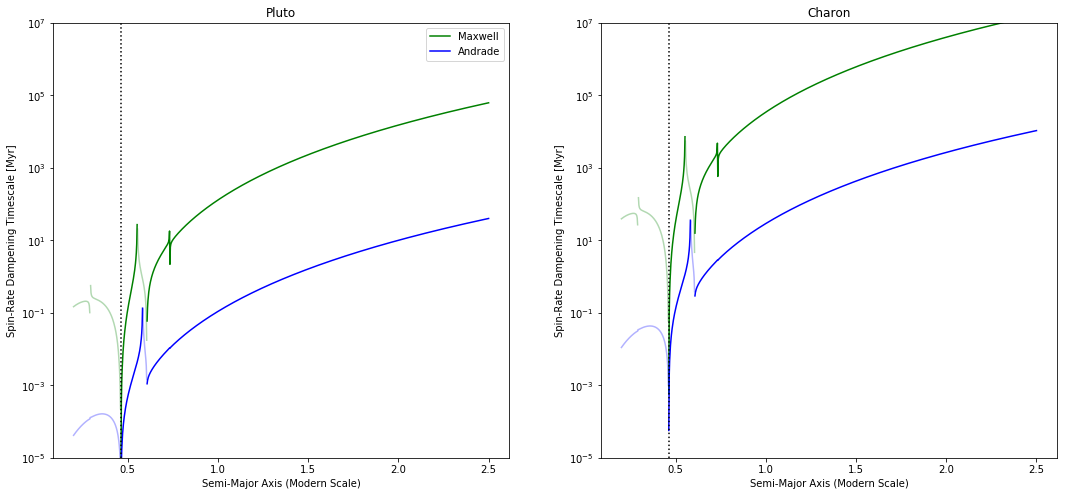

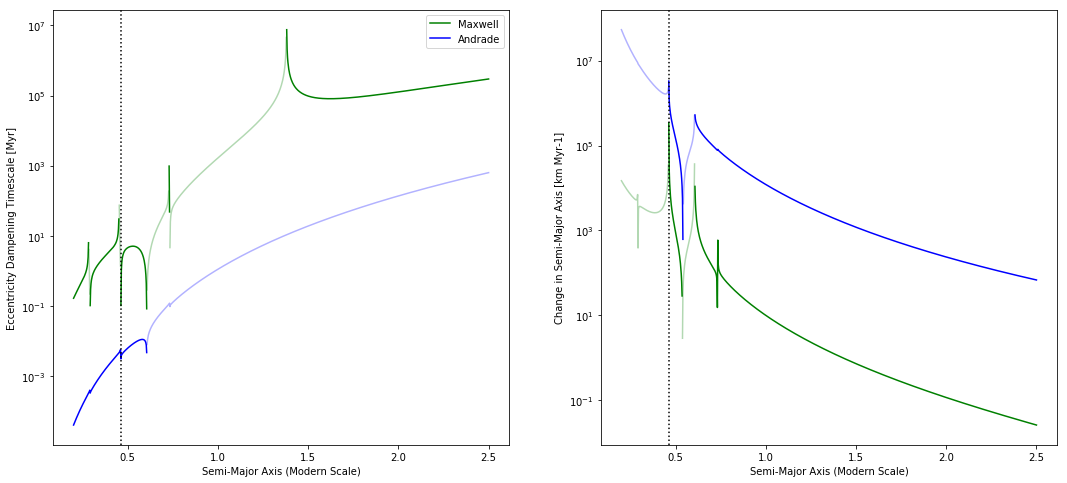

In [13]:
fig1, axes1 = plt.subplots(1, 2, figsize=(18,8))
fig2, axes2 = plt.subplots(1, 2, figsize=(18,8))

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    # Get Data
    tau_O_pluto = spin_rate_timescale_pluto_byrheo[rheo_name]
    tau_O_charon = spin_rate_timescale_charon_byrheo[rheo_name]
    da_dt = semi_major_axis_derivative_byrheo[rheo_name]
    tau_e = eccentricity_timescale_byrheo[rheo_name]
    
    # Flip negatives
    tau_O_neg_pluto = np.zeros_like(tau_O_pluto)
    tau_O_neg_pluto[tau_O_pluto < 0.] = -tau_O_pluto[tau_O_pluto < 0.]
    tau_O_neg_pluto[tau_O_neg_pluto <= 0.] = np.nan
    tau_O_pluto[tau_O_pluto <= 0.] = np.nan
    
    tau_O_neg_charon = np.zeros_like(tau_O_charon)
    tau_O_neg_charon[tau_O_charon < 0.] = -tau_O_charon[tau_O_charon < 0.]
    tau_O_neg_charon[tau_O_neg_charon <= 0.] = np.nan
    tau_O_charon[tau_O_charon <= 0.] = np.nan
    
    da_dt_neg = np.zeros_like(da_dt)
    da_dt_neg[da_dt < 0.] = -da_dt[da_dt < 0.]
    da_dt_neg[da_dt_neg <= 0.] = np.nan
    da_dt[da_dt <= 0.] = np.nan
    
    tau_e_neg = np.zeros_like(tau_e)
    tau_e_neg[tau_e < 0.] = -tau_e[tau_e < 0.]
    tau_e_neg[tau_e_neg <= 0.] = np.nan
    tau_e[tau_e <= 0.] = np.nan
    
    # Spin Timescales
    axes1[0].plot(semi_major_axis_scale, tau_O_pluto, style, label=rheo_name)
    axes1[0].plot(semi_major_axis_scale, tau_O_neg_pluto, style, alpha=0.3)
    axes1[1].plot(semi_major_axis_scale, tau_O_charon, style, label=rheo_name)
    axes1[1].plot(semi_major_axis_scale, tau_O_neg_charon, style, alpha=0.3)
    
    # Eccentricity Timescales
    axes2[0].plot(semi_major_axis_scale, tau_e, style, label=rheo_name)
    axes2[0].plot(semi_major_axis_scale, tau_e_neg, style, alpha=0.3)
    
    # Semi-major Axis
    axes2[1].plot(semi_major_axis_scale, da_dt, style, label=rheo_name)
    axes2[1].plot(semi_major_axis_scale, da_dt_neg, style, alpha=0.3)

# Add spin-sync location
spin_sync_semi_a_au = orbital_motion2semi_a(spin_frequency[0], mass_pluto, mass_charon) / modern_semi_major_axis
axes1[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes1[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes2[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes2[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes1[0].set_title('Pluto')
axes1[1].set_title('Charon')
axes1[0].set_xlabel('Semi-Major Axis (Modern Scale)')
axes1[1].set_xlabel('Semi-Major Axis (Modern Scale)')
axes1[0].set_ylabel('Spin-Rate Dampening Timescale [Myr]')
axes1[1].set_ylabel('Spin-Rate Dampening Timescale [Myr]')
axes1[0].set_yscale('log')
axes1[1].set_yscale('log')
axes1[0].legend(loc='best')
axes1[0].set_ylim((1e-5, 1e7))
axes1[1].set_ylim((1e-5, 1e7))

axes2[0].set_xlabel('Semi-Major Axis (Modern Scale)')
axes2[0].set_ylabel('Eccentricity Dampening Timescale [Myr]')
axes2[0].set_yscale('log')
axes2[1].set_xlabel('Semi-Major Axis (Modern Scale)')
axes2[1].set_ylabel('Change in Semi-Major Axis [km Myr-1]')
axes2[1].set_yscale('log')
# axes2[0].set_ylim((1e-9, 1e1))
# axes2[1].set_ylim((1e-6, 1e7))
axes2[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()